In [2]:
from datasets import load_dataset
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch

# wit = load_dataset("google/wit")
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"

tokeniser = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

In [ ]:
from PIL import Image
import os

images = []
for i in range(len(os.listdir("WIT_Images"))):
    try:
        image = Image.open(f"WIT_Images\\{i}.png")
        images.append(image)
    except Exception as ex:
        print(ex)

In [4]:
from datasets import load_dataset

imagenette = load_dataset(
    "frgfm/imagenette",
    "full_size",
    split="train",
    ignore_verifications=False
)
imagenette

Found cached dataset imagenette (C:/Users/jovin/.cache/huggingface/datasets/frgfm___imagenette/full_size/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)


Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

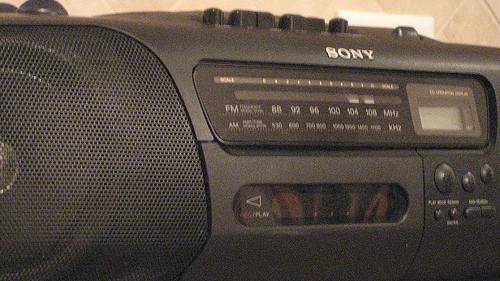

In [5]:
images = [imagenette[i]['image'] for i in range(len(imagenette))]
images[0]

In [6]:
from tqdm.auto import tqdm
import numpy as np

batch_size = 16
image_arr = None

# TODO ONLY DO ONCE AND THEN SAVE
for i in tqdm(range(0, len(images), batch_size)):
    try:
        batch = images[i:i+batch_size]
        batch = processor(
            text=None,
            images=batch,
            return_tensors="pt",
            padding=True
        )["pixel_values"].to(device)
        batch_emb = model.get_image_features(pixel_values=batch).squeeze(0)
        batch_emb = batch_emb.cpu().detach().numpy()
        if image_arr is None:
            image_arr = batch_emb
        else:
            image_arr = np.concatenate((image_arr, batch_emb), axis=0)
    except Exception as ex:
        print(ex)

image_arr.shape

100%|██████████| 592/592 [13:12<00:00,  1.34s/it]


(9469, 512)

In [7]:
image_arr = image_arr / np.linalg.norm(image_arr, axis=0)
image_arr.min(), image_arr.min()

(-0.056600656, -0.056600656)

In [31]:
import pickle

with open("imagenette_array.obj", "wb") as image_arr_file:
    pickle.dump(image_arr, image_arr_file)

In [32]:
with open("imagenette_array.obj", "rb") as image_arr_file:
    image_arr = pickle.load(image_arr_file)

(1, 9469)
86: 0.5822057723999023


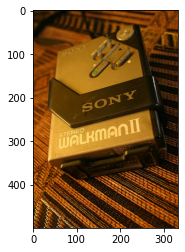

139: 0.5758647918701172


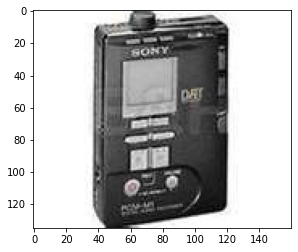

960: 0.573666512966156


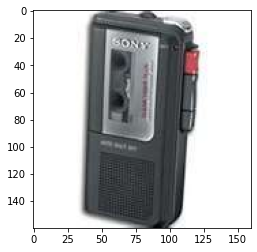

23: 0.5697412490844727


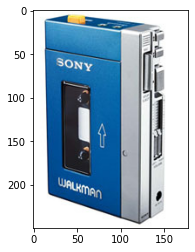

364: 0.5631449222564697


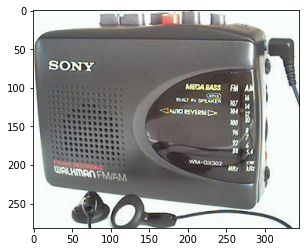

In [43]:
import matplotlib.pyplot as plt

prompt = "Sony"
inputs = tokeniser(prompt, return_tensors="pt")
text_emb = model.get_text_features(**inputs)
text_emb.shape

text_emb = text_emb.cpu().detach().numpy()
scores = np.dot(text_emb, image_arr.T)
print(scores.shape)

best = np.argsort(-scores[0])[:5]
for i in best:
    print(f"{i}: {scores[0][i]}")
    plt.imshow(images[i], cmap='gray')
    plt.show()